# **Computational Creativity Project**

---

## **GANToon: Generative Adversarial Networks for tranforming face to caricature**

Sriram Vinnakota, Student ID: 200776055


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Logistics Code:

In [ ]:
from IPython.display import Image, display
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from matplotlib import pyplot as plt
from PIL import Image as ima

In [ ]:
#@title Defining dataset path
dataroot ='/content/drive/MyDrive/ram/dataset/train' #@param{typr: "string"}

In [ ]:
#@title Processing the dataset
transform = transforms.Compose([transforms.Scale(128),
                                transforms.Resize(128),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_images = dset.ImageFolder(root=dataroot, transform=transform)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [ ]:
#@title Dataset parameters

# default: 32
BATCH_SIZE = 32 # @param {type:"slider", min:4, max:64, step:4}

In [ ]:
#@title Loading the batch dataset

train_dataset = torch.utils.data.DataLoader(train_images, batch_size=BATCH_SIZE,
                                          shuffle=True)

In [ ]:
#@title Generator network structure


class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(3,64,(1, 4),(1, 2),(0, 1), bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(64,64,4,2,1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(64,128,4,2,1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(128,256,4,2,1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(256,512,4,2,1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(512,3000,4, bias=False),
        nn.BatchNorm2d(3000),
        nn.LeakyReLU(0.2, inplace=True),
        nn.ConvTranspose2d(3000, 512, 4, 1, 0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
        nn.Tanh()
    )

  def forward(self, input):
    output = self.main(input)
    return output


def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    m.weight.data.normal_(0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    m.weight.data.normal_(1.0, 0.02)
    m.bias.data.fill_(0)

gen = Generator()
gen.apply(weights_init)
print(gen)

Generator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(1, 4), stride=(1, 2), padding=(0, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, momentu

In [ ]:
#@title Discriminator network structure

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(3, 64, 8, 4, 2, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(128, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(256, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, input):
    if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
      output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
    else:
      output = self.main(input)

    return output.view(-1, 1)


disc = Discriminator()
disc.apply(weights_init)
print(disc)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Training Code:

In [ ]:
#@title Set up the training loop and run.
n_epochs =  100# @param{type: "integer"} 
lr_g = 0.0002# @param{type: "number"}
lr_d = 0.0002# @param{typr: "number"}
img_save_path = '/content/drive/MyDrive/ram/results' #@param{type: 'string'}

try:
  os.makedirs(img_save_path + "/" + 'real_face')
  os.makedirs(img_save_path + "/" + "generated")
except:
  pass
criterion = nn.BCELoss()
paired = torch.FloatTensor(32, 3, 128, 256)
real_face = torch.FloatTensor(32, 3, 128, 256)
caricature = torch.FloatTensor(32, 3, 128, 128)
label = torch.FloatTensor(32)
real_label = 1
fake_label = 0
paired = Variable(paired)
real_face = Variable(real_face)
label = Variable(label)
caricature = Variable(caricature)

optimizer_disc = optim.Adam(disc.parameters(), lr=lr_g, betas=(0.5, 0.999))
optimizer_gen = optim.Adam(gen.parameters(), lr=lr_d, betas=(0.5, 0.999))
for epoch in range(n_epochs):
    for i, data in enumerate(train_dataset):
        paired_cpu, _ = data
        caricature_cpu = paired_cpu[:, :, :,
                              128:]
        batch_size = paired_cpu.size(0)
        with torch.no_grad():
            paired.resize_(paired_cpu.size()).copy_(paired_cpu)
            real_face.resize_(paired_cpu.size()).copy_(paired_cpu)
            caricature.resize_(caricature_cpu.size()).copy_(caricature_cpu)
        real_face.data[:, 0, :, int(128):] = 2 * 117.0 / 255.0 - 1.0
        real_face.data[:, 1, :, int(128):] = 2 * 104.0 / 255.0 - 1.0
        real_face.data[:, 2, :, int(128):] = 2 * 123.0 / 255.0 - 1.0

        # train with real
        disc.zero_grad()
        with torch.no_grad():
            label.resize_(batch_size).fill_(real_label)

        output = disc(caricature)
        label_r = label.unsqueeze(1)
        disc_loss_real = criterion(output, label_r)
        disc_loss_real.backward()
        Disc_real = output.data.mean()

        fake = gen(real_face)
        label.data.fill_(fake_label)
        output = disc(fake.detach())
        label_f = label.unsqueeze(1)
        disc_loss_fake = criterion(output, label_f)
        disc_loss_fake.backward()
        Disc_gen = output.data.mean()
        disc_loss = disc_loss_real + disc_loss_fake
        optimizer_disc.step()

        gen.zero_grad()
        label.data.fill_(real_label)
        output = disc(fake)
        label_d = label.unsqueeze(1)
        gen_loss = criterion(output, label_d)

        Matrix_l2 = caricature.clone()
        l2 = 0.998
        Matrix_l2.data.fill_(l2)

        gen_l2 = (fake - caricature).pow(2)
        gen_l2 = gen_l2 * Matrix_l2
        gen_l2 = gen_l2.mean()

        gen_error = (1 - l2) * gen_loss + l2 * gen_l2

        gen_error.backward()

        D_G_z2 = output.data.mean()
        optimizer_gen.step()
        print('[%d/%d][%d/%d] disc_loss: %.4f gen_loss: %.4f / %.4f D(x)_loss: %.4f D(G(z))_loss: %.4f'
              % (epoch, n_epochs, i, len(train_dataset),
                  disc_loss.data, gen_loss.data, gen_l2.data, Disc_real, Disc_gen,))
        if i % 100 == 0:
            vutils.save_image(real_face.data, img_save_path + '/' + 'real_face/real_face_epoch_%03d.png' % (epoch))
            gan_img = real_face.clone()
            gan_img.data[:, :, :, 128:] = fake.data
            vutils.save_image(gan_img.data, img_save_path  + '/' + 'generated/generated_epoch_%03d.png' % (epoch))
            display(Image(img_save_path  + '/' + 'generated/generated_epoch_%03d.png' % (epoch)))

In [ ]:
#@title Save model to GDrive

# from google.colab import drive
# drive.mount('/content/gdrive')

gen_save_name = 'gen' #@param{type: 'string'}
gen_save_name += '.pth'  # Set extension separately
disc_save_name = 'disc' #@param{type: 'string'}
disc_save_name += '.pth' # Set extension separately

path = '/content/drive/MyDrive/ram/models' #@param{type: 'string'}
full_path_g = F"{path}/{gen_save_name}" 
full_path_d = F"{path}/{disc_save_name}" 

In [ ]:
torch.save(gen.state_dict(), full_path_g)
torch.save(disc.state_dict(), full_path_d)

## Generation Code:





In [ ]:
#@title Download Saved Model

import gdown, os

url = "https://drive.google.com/drive/folders/14sH75XXOY1BO07BHFMZ1-BojHM3L2pLM?usp=sharing"

download_successful = None # A workaround to make sure that gdown downloads the whole folder successfully, see https://github.com/wkentaro/gdown/issues/43
while download_successful == None:
  download_successful = gdown.download_folder(url, quiet=True, use_cookies=False)
  os.system('rm ~/.cache/gdown/cookies.json')


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


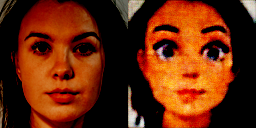

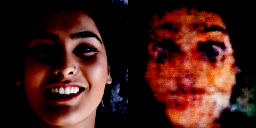

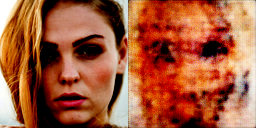

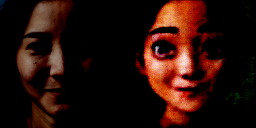

In [ ]:
#@title Load model and generate images

full_path_g = "/content/models/gen.pth"
full_path_d = "/content/models/disc.pth"
test_data_path = "/content/drive/MyDrive/ram/dataset/test" #@param {type: "string"}

try:
  os.makedirs(test_data_path + "/" + 'preprocessed')
  os.makedirs("results")
except:
  pass
dir1 = test_data_path
for img in os.listdir(dir1):
    if img.endswith('.png'):
        image1 = ima.open(dir1+ "/" + img)
        image1 = image1.resize((128, 128))
        image1_size = image1.size
        new_image1 = ima.new('RGB',(image1_size[0], image1_size[1]), (0,0,0))
        new_image = ima.new('RGB',(2*image1_size[0], image1_size[1]), (0,0,0))
        new_image.paste(image1,(0,0))
        new_image.paste(new_image1,(image1_size[0],0))
        new_image.save(dir1 + "/" + "preprocessed/"+ img,"PNG")

transform = transforms.Compose([transforms.Scale(128),
                                transforms.Resize(128),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = dset.ImageFolder(root=dir1, transform=transform)
assert dataset
image_src = torch.utils.data.DataLoader(dataset, batch_size=1,
                                         shuffle=True)
G = Generator()
G.load_state_dict(torch.load(full_path_g))

real_face = torch.FloatTensor(32, 3, 128, 256)

real_face = Variable(real_face)

with torch.no_grad():
    G.eval()
    for n, (x, _) in enumerate(image_src):
        x = x.to(device)
        real_face.resize_(x.size()).copy_(x)
        real_face.data[:, 0, :, int(128):] = 2 * 117.0 / 255.0 - 1.0
        real_face.data[:, 1, :, int(128):] = 2 * 104.0 / 255.0 - 1.0
        real_face.data[:, 2, :, int(128):] = 2 * 123.0 / 255.0 - 1.0
        G_recon = G(real_face)
        recon_image = real_face.clone()
        recon_image.data[:, :, :, 128:] = G_recon.data
        result = recon_image
        path = os.path.join('results', str(n + 1) + '.png')
        vutils.save_image(result.data, path)
        display(Image(path))


## **Secondary Generator Architicture**
### I have also used this generator configuration to train the model which took more than 6 hours for 90 epoch and the generated output is not as good as above model, this model is also trained and saved, you can get the access by [clicking here](https://drive.google.com/drive/folders/1k30GRN7Nvim2DjXJ1adToFnOW2l0RlZj?usp=sharing)

In [ ]:
#@title U-Net architicture
class _netG(nn.Module):
    def __init__(self):
        super(_netG, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3,512,(1, 4),(1, 2),(0, 1), bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512,512,4,2,1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512,256,4,2,1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256,128,4,2,1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128,64,4,2,1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64,32,4, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(32, 64, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output

In [ ]:
import gdown, os

url = "https://drive.google.com/drive/folders/1k30GRN7Nvim2DjXJ1adToFnOW2l0RlZj?usp=sharing"

download_successful = None 
while download_successful == None:
  download_successful = gdown.download_folder(url, quiet=True, use_cookies=False)
  os.system('rm ~/.cache/gdown/cookies.json')

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


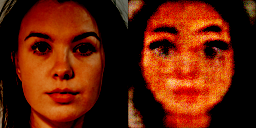

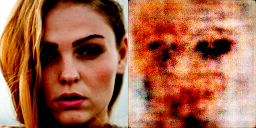

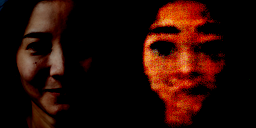

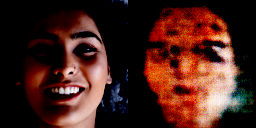

In [ ]:

full_path_g = "/content/models/netG.pth"
test_data_path = "/content/drive/MyDrive/ram/dataset/test" #@param {type: "string"}

try:
  os.makedirs("results")
  os.makedirs(test_data_path + "/" + 'preprocessed')
except:
  pass
dir1 = test_data_path
for img in os.listdir(dir1):
    if img.endswith('.png'):
        image1 = ima.open(dir1+ "/" + img)
        image1 = image1.resize((128, 128))
        image1_size = image1.size
        new_image1 = ima.new('RGB',(image1_size[0], image1_size[1]), (0,0,0))
        new_image = ima.new('RGB',(2*image1_size[0], image1_size[1]), (0,0,0))
        new_image.paste(image1,(0,0))
        new_image.paste(new_image1,(image1_size[0],0))
        new_image.save(dir1 + "/" + "preprocessed/"+ img,"PNG")

transform = transforms.Compose([transforms.Scale(128),
                                transforms.Resize(128),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = dset.ImageFolder(root=dir1, transform=transform)
assert dataset
image_src = torch.utils.data.DataLoader(dataset, batch_size=1,
                                         shuffle=True)
G = _netG()
G.load_state_dict(torch.load(full_path_g)["state_dict"])

real_face = torch.FloatTensor(32, 3, 128, 256)

real_face = Variable(real_face)

with torch.no_grad():
    G.eval()
    for n, (x, _) in enumerate(image_src):
        real_face.resize_(x.size()).copy_(x)
        real_face.data[:, 0, :, int(128):] = 2 * 117.0 / 255.0 - 1.0
        real_face.data[:, 1, :, int(128):] = 2 * 104.0 / 255.0 - 1.0
        real_face.data[:, 2, :, int(128):] = 2 * 123.0 / 255.0 - 1.0
        G_recon = G(real_face)
        recon_image = real_face.clone()
        recon_image.data[:, :, :, 128:] = G_recon.data
        result = recon_image
        path = os.path.join('results', str(n + 1) + '.png')
        vutils.save_image(result.data, path)
        display(Image(path))
